# Read Data First

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from lmfit.models import QuadraticModel, LorentzianModel, LinearModel
from lmfit import Model, Minimizer, Parameters, report_fit
import uncertainties as unc
import uncertainties.unumpy as unp

import math

def findarg(data, value):
    arg = 0
    for wl in data:
        if wl<value:
            arg = arg + 1
        else:
            return arg
        
    return arg

def integrate (wavelength, intensity, Index):
    sum = 0
    for i in Index:
        sum += intensity[i]*(wavelength[i+1]-wavelength[i])
    return sum

#EL2 - 98 data
sinData = []

#EL2 - 97 higher-dose data
sioData1 = []

#EL2 - 97 lower-dose data
sioData2 = []

for i in [3,6,9,12,15,18]:
    sinData.append(pd.read_csv('sin_m3_'+ str(i) + '.csv'))
    sioData1.append(pd.read_csv('sio_m3_'+ str(i) + '.csv'))

for i in [3,6]:
    sioData2.append(pd.read_csv('sio_m9_'+ str(i) + '.csv'))

nvModel_sio = pd.read_csv('nv_model - EL2-97.csv')
radModel_sio = pd.read_csv('gallium_model - EL2-97.csv')
sivModel_sio = pd.read_csv('siv_model - EL2-97.csv')

nvModel_sin = pd.read_csv('nv_model - EL2-98.csv')
radModel_sin = pd.read_csv('gallium_model - EL2-98.csv')
sivModel_sin = pd.read_csv('siv_model - EL2-98.csv')


# Define fitting range and fitting functions for EL2-98

In [2]:
regionMin = 625.5
regionMax = 792.5

argMin = findarg(sinData[0]['W'], regionMin)
argMax = findarg(sinData[0]['W'], regionMax)

Index = list(range(argMin, argMax))

nvIntensity = np.array(nvModel_sin['I'])
sivIntensity = np.array(sivModel_sin['I'])
radIntensity = np.array(radModel_sin['I'])

nvSum = integrate(sinData[0]['W'], nvIntensity, Index)
sivSum = integrate(sinData[0]['W'], sivIntensity, Index)
radSum = integrate(sinData[0]['W'], radIntensity, Index)


# currentDataIntensity = np.array(data['I'])
# currentDataWavelength = np.array(data['W'])

def fcn2min(params, x, data):
    """Model a quadradic background + nv & siv & irradiation signal and subtract data."""
    nv_amp = params['nv_amp']
    siv_amp = params['siv_amp']
    rad_amp = params['rad_amp']
    a = params['a']
    b = params['b']
    c = params['c']
    model = a*x**2+b*x+c
    return model + nv_amp*nvIntensity[Index] + siv_amp*sivIntensity[Index] + rad_amp*radIntensity[Index] - data

def getIntensityRatio_sin (data):

    # get the full intensity from the data
    fullIntensity = integrate(np.array(data['W']), np.array(data['I']), Index)

    # create a set of Parameters
    params = Parameters()
    params.add('nv_amp', value=1, min=0)
    params.add('siv_amp', value=1, min=0)
    params.add('rad_amp', value=1, min=0)
    # params.add('a', value=0, vary =  False)
    params.add('a', value=0)
    params.add('b', value=0)
    params.add('c', value=0)
    minner = Minimizer(fcn2min, params, fcn_args=(np.array(data['W'])[Index], np.array(data['I'])[Index]))
    result = minner.minimize()
    amps = []

    #NV-, SiV-, Irradiation

    # amps.append(unc.ufloat(result.params['nv_amp'].value,  result.params['nv_amp'].stderr)/fullIntensity)
    # amps.append(unc.ufloat(result.params['siv_amp'].value,  result.params['siv_amp'].stderr)/fullIntensity)
    # amps.append(unc.ufloat(result.params['rad_amp'].value,  result.params['rad_amp'].stderr)/fullIntensity)

    
    # amps.append(result.params['nv_amp'].value/fullIntensity)
    # amps.append(result.params['siv_amp'].value/fullIntensity)
    # amps.append(result.params['rad_amp'].value/fullIntensity)

    try:
        amps.append(unc.ufloat(result.params['nv_amp'].value,result.params['nv_amp'].stderr)/fullIntensity)
    except:
        amps.append(unc.ufloat(result.params['nv_amp'].value,0)/fullIntensity)  

    try:
        amps.append(unc.ufloat(result.params['siv_amp'].value,result.params['siv_amp'].stderr)/fullIntensity)
    except:
        amps.append(unc.ufloat(result.params['siv_amp'].value,0)/fullIntensity)   

    try:
        amps.append(unc.ufloat(result.params['rad_amp'].value,result.params['rad_amp'].stderr)/fullIntensity)
    except:
        amps.append(unc.ufloat(result.params['rad_amp'].value,0)/fullIntensity)
    
    return amps

### Calculate the isolated intensities and plot

In [3]:
sin_nv_result = []
sin_siv_result = []
sin_rad_result = []


for data in sinData:
    fitting_amps = getIntensityRatio_sin(data)
    sin_nv_result.append(nvSum * fitting_amps[0])
    sin_siv_result.append(sivSum * fitting_amps[1]) 
    sin_rad_result.append(radSum * fitting_amps[2])
    # print(sin_siv_result)
    # print(sin_rad_result)
    # print('next')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


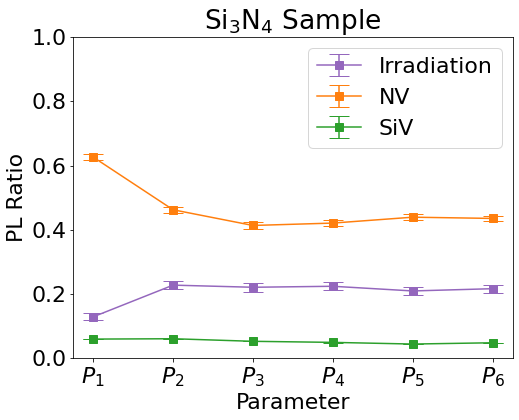

In [4]:
# x = [1,2,3,4,5,6]
# plt.errorbar(x,unp.nominal_values(sin_nv_result), yerr = unp.std_devs(sin_nv_result))
# plt.plot(unp.nominal_values(sin_nv_result))
# plt.plot(unp.nominal_values(sin_siv_result))
# plt.plot(unp.nominal_values(sin_rad_result))

plt.rcParams.update({'font.size': 22})
x1=[0,1,2,3,4,5,6,7]
x2=[0,1,2,3,4,5]

cm = 1/2.54 
fig = plt.figure(figsize=(20*cm, 15*cm))

plt.errorbar(x2,unp.nominal_values(sin_rad_result), yerr=unp.std_devs(sin_rad_result), fmt="s-", color="C4", markersize=8, capsize=10, label = 'Irradiation')
plt.errorbar(x2,unp.nominal_values(sin_nv_result), yerr=unp.std_devs(sin_nv_result), fmt="s-", color="C1", markersize=8, capsize=10, label = 'NV')
plt.errorbar(x2,unp.nominal_values(sin_siv_result), yerr=unp.std_devs(sin_siv_result), fmt="s-", color="C2", markersize=8, capsize=10, label = 'SiV')



plt.ylim(0,1)



# plt.errorbar(x2,unp.nominal_values(sin_nv_yield)*100, yerr=unp.std_devs(sin_nv_yield)*100, fmt="s", markersize=8, capsize=5)
# plt.errorbar(x2,unp.nominal_values(sin_siv_yield)*100, yerr=unp.std_devs(sin_siv_yield)*100, fmt="o", markersize=8, capsize=5)
# plt.errorbar(x1,unp.nominal_values(sio_siv_yield)*100, yerr=unp.std_devs(sio_siv_yield)*100, fmt="o", markersize=8, capsize=5)

plt.ylabel('PL Ratio')
plt.xlabel('Parameter')

plt.xticks([0,1,2,3,4,5], ('$P_1$','$P_2$','$P_3$','$P_4$','$P_5$','$P_6$'))


plt.title('Si$_3$N$_4$ Sample')

plt.legend()


fig.savefig('SiN_defect_ratio.eps', format= 'eps',transparent=True)

# Define fitting range and fitting functions for EL2-97

In [5]:
regionMin = 625.5
regionMax = 792.5

argMin = findarg(sioData1[0]['W'], regionMin)
argMax = findarg(sioData1[0]['W'], regionMax)

Index = list(range(argMin, argMax))

nvIntensity = np.array(nvModel_sio['I'])
sivIntensity = np.array(sivModel_sio['I'])
radIntensity = np.array(radModel_sio['I'])

nvSum = integrate(sioData1[0]['W'], nvIntensity, Index)
sivSum = integrate(sioData1[0]['W'], sivIntensity, Index)
radSum = integrate(sioData1[0]['W'], radIntensity, Index)


# currentDataIntensity = np.array(data['I'])
# currentDataWavelength = np.array(data['W'])

def fcn2min(params, x, data):
    """Model a quadradic background + nv & siv & irradiation signal and subtract data."""
    nv_amp = params['nv_amp']
    siv_amp = params['siv_amp']
    rad_amp = params['rad_amp']
    a = params['a']
    b = params['b']
    c = params['c']
    model = a*x**2+b*x+c
    return model + nv_amp*nvIntensity[Index] + siv_amp*sivIntensity[Index] + rad_amp*radIntensity[Index] - data

def getIntensityRatio_sio_high (data):

    # get the full intensity from the data
    fullIntensity = integrate(np.array(data['W']), np.array(data['I']), Index)

    # create a set of Parameters
    params = Parameters()
    params.add('nv_amp', value=1, min=0)
    params.add('siv_amp', value=1, min=0)
    params.add('rad_amp', value=1, min=0)
    # params.add('a', value=0, vary =  False)
    params.add('a', value=0, vary = False)
    params.add('b', value=0, vary = False)
    params.add('c', value=0)
    minner = Minimizer(fcn2min, params, fcn_args=(np.array(data['W'])[Index], np.array(data['I'])[Index]))
    result = minner.minimize()
    amps = []

    #NV-, SiV-, Irradiation

    # amps.append(result.params['nv_amp'].value/fullIntensity)
    # amps.append(result.params['siv_amp'].value/fullIntensity)
    # amps.append(result.params['rad_amp'].value/fullIntensity)
    try:
        amps.append(unc.ufloat(result.params['nv_amp'].value,result.params['nv_amp'].stderr)/fullIntensity)
    except:
        amps.append(unc.ufloat(result.params['nv_amp'].value,0)/fullIntensity)  

    try:
        amps.append(unc.ufloat(result.params['siv_amp'].value,result.params['siv_amp'].stderr)/fullIntensity)
    except:
        amps.append(unc.ufloat(result.params['siv_amp'].value,0)/fullIntensity)   

    try:
        amps.append(unc.ufloat(result.params['rad_amp'].value,result.params['rad_amp'].stderr)/fullIntensity)
    except:
        amps.append(unc.ufloat(result.params['rad_amp'].value,0)/fullIntensity)    

    
    return amps

    
def getIntensityRatio_sio_low (data):

    # get the full intensity from the data
    fullIntensity = integrate(np.array(data['W']), np.array(data['I']), Index)

    # create a set of Parameters
    params = Parameters()
    params.add('nv_amp', value=1, min=0)
    params.add('siv_amp', value=1, min=0)
    params.add('rad_amp', value=1, min=0)
    # params.add('a', value=0, vary =  False)
    params.add('a', value=0, vary = True)
    params.add('b', value=0, vary = True)
    params.add('c', value=0)
    minner = Minimizer(fcn2min, params, fcn_args=(np.array(data['W'])[Index], np.array(data['I'])[Index]))
    result = minner.minimize()
    amps = []

    #NV-, SiV-, Irradiation

    amps.append(result.params['nv_amp'].value/fullIntensity)
    amps.append(result.params['siv_amp'].value/fullIntensity)
    amps.append(result.params['rad_amp'].value/fullIntensity)
    
    return amps

### Calculate the isolated intensities and plot

In [6]:
sio_nv_result = []
sio_siv_result = []
sio_rad_result = []


for data in sioData1:
    fitting_amps = getIntensityRatio_sio_high(data)
    sio_nv_result.append(nvSum * fitting_amps[0])
    sio_siv_result.append(sivSum * fitting_amps[1]) 
    sio_rad_result.append(radSum * fitting_amps[2])

for data in sioData2:
    fitting_amps = getIntensityRatio_sio_low(data)
    sio_nv_result.append(nvSum * fitting_amps[0])
    sio_siv_result.append(sivSum * fitting_amps[1]) 
    sio_rad_result.append(radSum * fitting_amps[2])

# Read PL data

In [7]:
sinPL = pd.read_csv('sin_PL.csv')
sioPL = pd.read_csv('sio_PL.csv')

sio_nv_confocal_intensity = []
sio_siv_confocal_intensity = []
sio_rad_confocal_intensity = []

sin_nv_confocal_intensity = []
sin_siv_confocal_intensity = []
sin_rad_confocal_intensity = []

### multiply PL intensity by the ratio to get PL intensity (in ct/s) for defects

In [8]:
for i in [0,1,2,3,4,5,6,7]:
    sio_nv_confocal_intensity.append(sio_nv_result[i]*unc.ufloat(sioPL['PL'][i],sioPL['STD'][i]))
    sio_siv_confocal_intensity.append(sio_siv_result[i]*unc.ufloat(sioPL['PL'][i],sioPL['STD'][i]))
    sio_rad_confocal_intensity.append(sio_rad_result[i]*unc.ufloat(sioPL['PL'][i],sioPL['STD'][i]))

for i in [0,1,2,3,4,5]:
    sin_nv_confocal_intensity.append(sin_nv_result[i]*unc.ufloat(sinPL['PL'][i],sinPL['STD'][i]))
    sin_siv_confocal_intensity.append(sin_siv_result[i]*unc.ufloat(sinPL['PL'][i],sinPL['STD'][i]))
    sin_rad_confocal_intensity.append(sin_rad_result[i]*unc.ufloat(sinPL['PL'][i],sinPL['STD'][i]))

### Plot the intensities

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


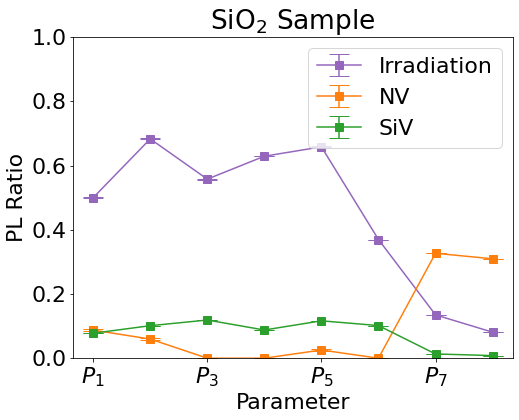

In [9]:
plt.rcParams.update({'font.size': 22})
x1=[0,1,2,3,4,5,6,7]
# x2=[0,1,2,3,4,5]

cm = 1/2.54 
fig = plt.figure(figsize=(20*cm, 15*cm))

plt.errorbar(x1,unp.nominal_values(sio_rad_result), yerr=unp.std_devs(sio_rad_result), fmt="s-", color="C4", markersize=8, capsize=10, label = 'Irradiation')
plt.errorbar(x1,unp.nominal_values(sio_nv_result), yerr=unp.std_devs(sio_nv_result), fmt="s-", color="C1", markersize=8, capsize=10, label = 'NV')
plt.errorbar(x1,unp.nominal_values(sio_siv_result), yerr=unp.std_devs(sio_siv_result), fmt="s-", color="C2", markersize=8, capsize=10, label = 'SiV')


plt.ylim(0,1)



# plt.errorbar(x2,unp.nominal_values(sin_nv_yield)*100, yerr=unp.std_devs(sin_nv_yield)*100, fmt="s", markersize=8, capsize=5)
# plt.errorbar(x2,unp.nominal_values(sin_siv_yield)*100, yerr=unp.std_devs(sin_siv_yield)*100, fmt="o", markersize=8, capsize=5)
# plt.errorbar(x1,unp.nominal_values(sio_siv_yield)*100, yerr=unp.std_devs(sio_siv_yield)*100, fmt="o", markersize=8, capsize=5)
plt.title('SiO$_2$ Sample')
plt.ylabel('PL Ratio')
plt.xlabel('Parameter')

plt.xticks([0,2,4,6], ('$P_1$','$P_3$','$P_5$','$P_7$'))



plt.legend()
fig.savefig('SiO_defect_ratio.eps', format= 'eps',transparent=True)

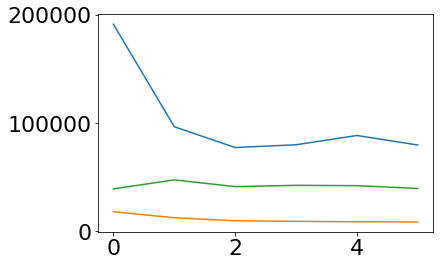

In [10]:
plt.plot(unp.nominal_values(sin_nv_confocal_intensity))
plt.plot(unp.nominal_values(sin_siv_confocal_intensity))
plt.plot(unp.nominal_values(sin_rad_confocal_intensity))

# Nomalize and get defect density (in cm^-2)

In [11]:
# define a formation yield for the SiV square calibration
squareYield = 0.05

# define the SiV square calibration sample implantation dose
squareDose = 1e11

# the measured single NV PL intnesity at 0.2 mW
singleNV = unc.ufloat(6647,1258.861201)

# the measured siv square PL intensity at 0.2mW
squarePL     = unc.ufloat(10300, 2485.532286)

# the measured FWHM of the laser beam (in cm)
fwhm = unc.ufloat(0.7, 0.02)*1e-4

In [12]:
sio_nv_density = []
sio_siv_density = []

sin_nv_density = []
sin_siv_density = []

#EL2-97 NV density

for ele in sio_nv_confocal_intensity:
    d = ele/singleNV/(math.pi*(fwhm/2)**2)
    sio_nv_density.append(d)
    

#EL2-98 NV density

for ele in sin_nv_confocal_intensity:
    d = ele/singleNV/(math.pi*(fwhm/2)**2)
    sin_nv_density.append(d)

#EL2-97 siv density

for ele in sio_siv_confocal_intensity:
    d = ele/squarePL*squareDose*squareYield
    sio_siv_density.append(d)

#EL2-98 siv density

for ele in sin_siv_confocal_intensity:
    d = ele/squarePL*squareDose*squareYield
    sin_siv_density.append(d)


### plot the densities

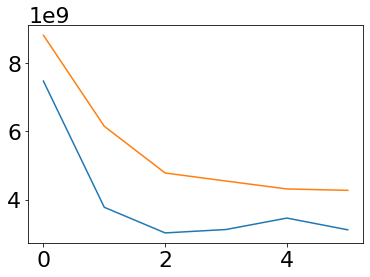

In [13]:
plt.plot(unp.nominal_values(sin_nv_density))
plt.plot(unp.nominal_values(sin_siv_density))

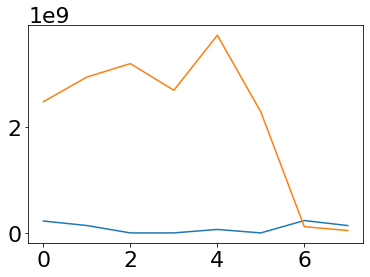

In [14]:
plt.plot(unp.nominal_values(sio_nv_density))
plt.plot(unp.nominal_values(sio_siv_density))

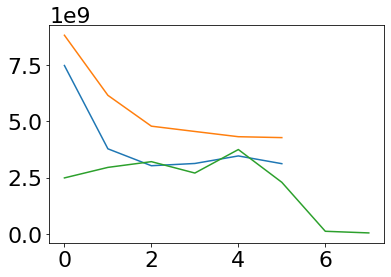

In [15]:
plt.plot(unp.nominal_values(sin_nv_density))
plt.plot(unp.nominal_values(sin_siv_density))
plt.plot(unp.nominal_values(sio_siv_density))

# get dose data

In [16]:
data = pd.read_csv('Dose.csv')

#dwell has unit s
dwell = data['DT']

#current has unit nA
current = []
# current = unc.ufloat(data['Current'],data['CE'])   
for i in range(12):
    current.append(unc.ufloat(data['C'][i],  data['CE'][i])*1e-9)
overlap = 3
multip =  data['Pass']

#diameter has unit m
diameter = []
for i in range(12):
    diameter.append(unc.ufloat(data['D'][i],  data['DE'][i])*1e-9)
radius = []
for i in range(12):
    radius.append(diameter[i]/2)
ctoe = 6.242e18

#dose in  cm^-2
dose = []
for i in range(12):
    dose.append(current[i]*ctoe*dwell[i]*overlap*multip[i]/(math.pi*radius[i]**2)/(100)**2)

# Divide density by dose to give the formation yield (without multiplacation of simulation results, which will make the yeild smaller)

In [17]:
sio_siv_yield = []
d = []
sin_nv_yield = []
sin_siv_yield = []

for i in [0,1,2,3,4,5,6,7]:
    y  = sio_siv_density[i]/dose[11-i]
    sio_siv_yield.append(y)

for i in [0,1,2,3,4,5]:
    y  = sin_siv_density[5-i]/dose[11-i]
    sin_siv_yield.append(y)

for i in [0,1,2,3,4,5]:
    y  = sin_nv_density[5-i]/dose[11-i]
    sin_nv_yield.append(y)

for i in [0,1,2,3,4,5,6,7,8,9,10]:
    d.append(dose[11-i])

### plot yield

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


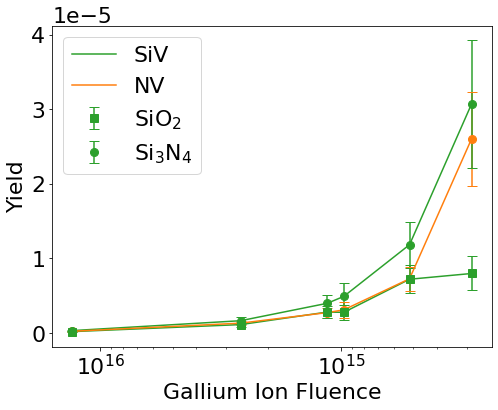

In [18]:
plt.rcParams.update({'font.size': 22})
x1=[0,1,2,3,4,5,6,7]
x2=[0,1,2,3,4,5]

cm = 1/2.54 
fig = plt.figure(figsize=(20*cm, 15*cm))
doseV = unp.nominal_values(d)

plt.errorbar(doseV[0:6],unp.nominal_values(sin_nv_yield)[0:6], yerr=unp.std_devs(sin_nv_yield)[0:6], fmt="o", color="C1", markersize=8, capsize=5)
plt.errorbar(doseV[0:6],unp.nominal_values(sio_siv_yield)[0:6], yerr=unp.std_devs(sio_siv_yield)[0:6], fmt="s", color="C2", markersize=8, capsize=5, label = 'SiO$_2$')
plt.errorbar(doseV[0:6],unp.nominal_values(sin_siv_yield), yerr=unp.std_devs(sin_siv_yield), fmt="o", color="C2", markersize=8, capsize=5, label = 'Si$_3$N$_4$')

plt.plot(doseV[0:6],unp.nominal_values(sio_siv_yield)[0:6], color="C2", label = 'SiV')
plt.plot(doseV[0:6],unp.nominal_values(sin_siv_yield)[0:6], color="C2" )
plt.plot(doseV[0:6],unp.nominal_values(sin_nv_yield), color="C1", label = 'NV')





# plt.errorbar(x2,unp.nominal_values(sin_nv_yield)*100, yerr=unp.std_devs(sin_nv_yield)*100, fmt="s", markersize=8, capsize=5)
# plt.errorbar(x2,unp.nominal_values(sin_siv_yield)*100, yerr=unp.std_devs(sin_siv_yield)*100, fmt="o", markersize=8, capsize=5)
# plt.errorbar(x1,unp.nominal_values(sio_siv_yield)*100, yerr=unp.std_devs(sio_siv_yield)*100, fmt="o", markersize=8, capsize=5)

plt.ylabel('Yield')
plt.xlabel('Gallium Ion Fluence')
plt.xscale('log')
plt.gca().invert_xaxis()
# plt.ylim(1e12,1e16)
# plt.xticks([0,3,6], ("{:.1e}".format(doseV[11]),"{:.1e}".format(doseV[8]),"{:.1e}".format(doseV[5])))

plt.legend()
fig.savefig('formation_yield.eps', format= 'eps',transparent=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


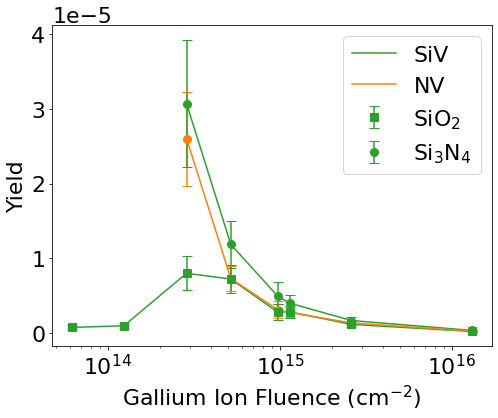

In [20]:
plt.rcParams.update({'font.size': 22})
x1=[0,1,2,3,4,5,6,7]
x2=[0,1,2,3,4,5]

cm = 1/2.54 
fig = plt.figure(figsize=(20*cm, 15*cm))
doseV = unp.nominal_values(d)

plt.errorbar(doseV[0:6],unp.nominal_values(sin_nv_yield)[0:6], yerr=unp.std_devs(sin_nv_yield)[0:6], fmt="o", color="C1", markersize=8, capsize=5)
plt.errorbar(doseV[0:8],unp.nominal_values(sio_siv_yield)[0:8], yerr=unp.std_devs(sio_siv_yield)[0:8], fmt="s", color="C2", markersize=8, capsize=5, label = 'SiO$_2$')
plt.errorbar(doseV[0:6],unp.nominal_values(sin_siv_yield), yerr=unp.std_devs(sin_siv_yield), fmt="o", color="C2", markersize=8, capsize=5, label = 'Si$_3$N$_4$')

plt.plot(doseV[0:8],unp.nominal_values(sio_siv_yield)[0:8], color="C2", label = 'SiV')
plt.plot(doseV[0:6],unp.nominal_values(sin_siv_yield)[0:6], color="C2" )
plt.plot(doseV[0:6],unp.nominal_values(sin_nv_yield), color="C1", label = 'NV')





# plt.errorbar(x2,unp.nominal_values(sin_nv_yield)*100, yerr=unp.std_devs(sin_nv_yield)*100, fmt="s", markersize=8, capsize=5)
# plt.errorbar(x2,unp.nominal_values(sin_siv_yield)*100, yerr=unp.std_devs(sin_siv_yield)*100, fmt="o", markersize=8, capsize=5)
# plt.errorbar(x1,unp.nominal_values(sio_siv_yield)*100, yerr=unp.std_devs(sio_siv_yield)*100, fmt="o", markersize=8, capsize=5)

plt.ylabel('Yield')
plt.xlabel('Gallium Ion Fluence (cm$^{-2})$')
plt.xscale('log')
# plt.gca().invert_xaxis()
# plt.ylim(1e12,1e16)
# plt.xticks([0,3,6], ("{:.1e}".format(doseV[11]),"{:.1e}".format(doseV[8]),"{:.1e}".format(doseV[5])))

plt.legend()
fig.savefig('formation_yield_all.eps', format= 'eps',transparent=True)